In [1]:
cd ..

/work


In [2]:
%load_ext autoreload
%autoreload 2

import time 
from src.dbscan import *
from src.utils import *
from src.metrics import *
from src.clusterization_performance import *
from src.datasets import Dataset
from src.dbscanrn_optimized import *
from src.dbscanrn import *
from src.normalization import *

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(0)
# plt.style.use('dark_background')

# Datasets

### Dataset from lecture

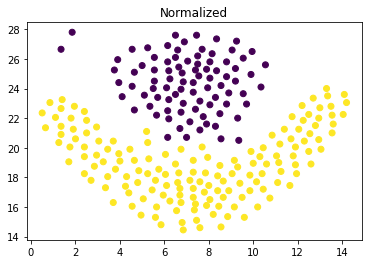

In [3]:
dataset = Dataset('./data/flame_dataset.txt')
X, y = dataset.X, dataset.y
display_points(X, y, 'Normalized', numerate=False)

# normalization = Norm()
# X = normalization.run(X)
# display_points(X, y, 'Original', numerate=False)


# DBSCAN (euclidean distance)

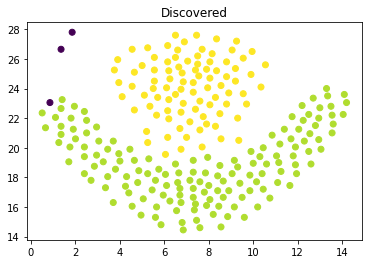

'./out/LOG_dbscan_flame_dataset_D2_R240_m23_e2.067_euclidean_distance.log'

In [4]:
timer_start = time.time()
params = {
    'epsilon': 2.067,
    'minPts': 23,
    'similarity': euclidean_distance
}

algorithm = DBSCAN(**params)

name = get_name(
    algorithm_name=algorithm.name, 
    dataset_name=dataset.name, 
    n_dimentions=dataset.n_dimentions, 
    n_rows=dataset.n_rows,
    **params
)

algorithm.log_output = f'./out/LOG_{name}.log'
algorithm.fit_transform(X)
total_runtime = (time.time() - timer_start) * 1000

display_points(algorithm.X, algorithm.y_pred, 'Discovered', numerate=False)
score = evaluate(algorithm.y_pred, y, algorithm.X)
algorithm.log_output

# OUT

In [5]:
timer_start = time.time()
logs = algorithm.get_logs()
mask = logs['operation'] == 'similarity_calculation'
similarity_calculation = logs[mask].groupby('point_id').sum().reset_index().drop(columns=['time [ms]'])
similarity_calculation.rename(columns={'value': '# of distance/similarity calculations'}, inplace=True)

out = pd.DataFrame({
    'point_id': np.arange(dataset.n_rows),
    'x': algorithm.X[:, 0],
    'y': algorithm.X[:, 1],
    'point_type': algorithm.state, # 1 - core, 0 - border, -1 - noise
    'CId': algorithm.y_pred # clusters: cluster identifier or -1 in the case of noise points
})

out = out.merge(similarity_calculation, on='point_id')
out.to_csv(f'./out/OUT_{name}.csv', index=False)
saving_OUT_time = (time.time() - timer_start) * 1000
out.head()

,point_id,x,y,point_type,CId,# of distance/similarity calculations
0,13,1.90,21.25,1,14,19.0
1,21,2.40,20.05,1,14,15.0
2,22,3.05,20.45,1,14,14.0
3,24,3.45,19.90,1,14,12.0
4,25,2.95,19.50,1,14,13.0


# STAT

In [6]:
timer_stat = time.time()
stat = pd.DataFrame({
    'name of the input fil': dataset.name,
    '# of dimensions of a point': dataset.n_dimentions,
    '# of points in the input file': dataset.n_rows,
    'epsilon': params['epsilon'] if 'epsilon' in params else '',
    'minPts': params['minPts'] if 'minPts' in params else '',
    'k':  params['k'] if 'k' in params else '',
    'similarity': params['similarity'].__name__,
    'values of dimensions of a reference point': '',
    'reading the input file': dataset.runtime,
    'normalization of vectors': '',
    "Eps-neighborhood timer": logs['time [ms]'][logs['operation'] == 'Eps_time'].sum(),
    'Clustering timer': logs['time [ms]'].max(),
    'saving results to OUT': saving_OUT_time,
    'total runtime': total_runtime,
    '# of discovered clusters': sum(out['CId'] > -1),
    '# of discovered noise points': sum(out['point_type'] == -1),
    '# of discovered core points': sum(out['point_type'] == 1),
    '# of discovered border points': sum(out['point_type'] == 0),
    'avg # of calculations of distance/similarity': out['# of distance/similarity calculations'].mean(),
    '|TP|': score['TP'],
    '|TN|': score['TN'],
    '# of pairs of points': len(algorithm.y_pred),
    'RAND': score['rand_score'],
    'Purity': score['purity'],
    'Silhouette coefficient': score['silhouette_score_euclidean'],
    'Davies Bouldin': score['davies_bouldin_score']
}, index=['values']).T
stat_time = time.time() - timer_stat
print(stat_time)
stat.to_csv(f'./out/STAT_{name}.csv', index=False)
stat

0.005385398864746094


,values
name of the input fil,flame_dataset
# of dimensions of a point,2
# of points in the input file,240
epsilon,2.067
minPts,23
k,
similarity,euclidean_distance
values of dimensions of a reference point,
reading the input file,31.357288
normalization of vectors,


# DEBUG

In [7]:
mask1 = logs['operation'] == '|Eps_neighbors|'
mask2 = logs['operation'] == 'Eps_neighbor_id'

debug1 = (
    logs[mask1]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'value', 
    )
)
debug1.reset_index(col_level=1, inplace=True)
debug1.columns.name = None

debug2 = (
    logs[mask2]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'string', 
        aggfunc=lambda x: ' '.join(x)
))   
debug2.reset_index(col_level=1, inplace=True)
debug2.columns.name = None

debug = debug1.merge(debug2, on='point_id')
debug.to_csv(f'./out/DEBUG_{name}.csv', index=False)
debug

,point_id,|Eps_neighbors|,Eps_neighbor_id
0,0.0,3.0,0;1;2
1,1.0,2.0,0;1
2,2.0,4.0,0;2;5;7
3,3.0,4.0,3;4;8;9
4,4.0,4.0,3;4;8;9
5,5.0,5.0,2;5;6;7;11
6,6.0,3.0,5;6;11
7,7.0,4.0,2;5;7;11
8,8.0,4.0,3;4;8;9
9,9.0,4.0,3;4;8;9
